In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import FuncFormatter as ff
plt.style.use('fivethirtyeight')

import re
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

from datetime import datetime, timedelta

In [6]:
#creates connection to mongodb
client = pymongo.MongoClient()
db = client.tweeter

In [7]:
#assings variable to table from mongo
bernie_coll = db.bernie_tweets
joe_coll = db.joe_tweets
pete_coll = db.pete_tweets
warren_coll = db.warren_tweets
amy_coll = db.amy_tweets
bloomberg_coll = db.bloomber_tweets

In [8]:
#retrieved data from mongo into a dataframe
bernie_df = pd.DataFrame(list(bernie_coll.find()))
joe_df = pd.DataFrame(list(joe_coll.find()))
pete_df = pd.DataFrame(list(pete_coll.find()))
warren_df = pd.DataFrame(list(warren_coll.find()))
amy_df = pd.DataFrame(list(amy_coll.find()))
bloomberg_df = pd.DataFrame(list(bloomberg_coll.find()))

In [9]:
#grabed debate dates from wikipedia
debates = pd.read_html('https://en.wikipedia.org/wiki/2020_Democratic_Party_presidential_debates')[2]

In [10]:
dnc_debates = pd.to_datetime(['June 26, 2019','June 27, 2019','July 30, 2019','July 31, 2019','September 12, 2019',
 'October 15, 2019','November 20, 2019','December 19, 2019','January 14, 2020',
 'February 7, 2020','February 19, 2020','February 25, 2020','March 15, 2020'])

In [11]:
def sentiment_analyser(df):
    """Analyses sentiment using TextBlob analyser from text in dataframe.

    Parameters
    ----------
    df : dataframe
        A dataframe that contains a text column labeled 'text', and requires a date column labeled as 'date'.

    Returns
    -------
    A new dateframe reindexed by date, with additional columns: year, month, day, wk_name, polarity, tweet, sent_pol.
    """
    
    #eliminates any rows that are null
    df = df[~df['text'].isnull()]
    df.loc[:,'text'] = df.loc[:,'text'].apply(lambda x: remove_url(x))
    n_df = df[~df['text'].isnull()]
    
    #creat list of values analysed by TextBlob
    sentiment_objects = [TextBlob(tweet) for tweet in n_df['text']]
    #create list of polarity valuesx and tweet text
    sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]
    #create dataframe containing the polarity value and tweet text
    sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])
    
    #merge dataframe with polarity values
    sent_df = n_df.merge(sentiment_df, left_on='text', right_on='tweet')
    
    #assing categorical values to polarity
    sent_pol = []
    for x in sent_df['polarity']:
        if x == 0.000000:
            sent_pol.append('neutral')
        elif x > 0.000000:
            sent_pol.append('positive')
        elif x < 0.000000:
            sent_pol.append('negative')
    
    sent_df['sent_pol'] = sent_pol
    
    #set date and generate columns 
    output_df = sent_df.set_index('date')
    output_df.index = pd.to_datetime(output_df.index)
    output_df['year'] = output_df.index.year
    output_df['month'] = output_df.index.month
    output_df['day'] = output_df.index.day
    output_df['wk_name'] = output_df.index.weekday_name
    
    return output_df

In [12]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [13]:
def plot_sentiment(polarity_score):
    """Creates a histogram of polarity score.  

    Parameters
    ----------
    polarity_score : int
        Polarity score ranging from -1 to 1.

    Returns
    -------
    A histogram.
    """
    
    #plot data
    fig, ax = plt.subplots(figsize=(8, 6))
    #plot histogram of the polarity values
    polarity_score.hist(bins=[-1, -0.90, -.80, -.70, -.60, -0.50, -.40 ,-.30, -0.20,-.10, 
                            0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1],
                 ax=ax,
                 color="purple")

    plt.title(title)
    return plt.show()

In [22]:
def tweets_per_day(df):
    """Creates a bar graph of tweets per day    

    Parameters
    ----------
    df : dataframe
        A text string of weekdays 

    Returns
    -------
    A bar graph ordered Monday to Sunday
    """
    
    cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    result = df['wk_name'].value_counts().reindex(cats).reset_index().rename(columns={'index':'weekday', 'wk_name':'num_tweets'})
    return result

In [15]:
#analyse sentiment for all candidates
bernie_sentiment = sentiment_analyser(bernie_df)
joe_sentiment = sentiment_analyser(joe_df)
pete_sentiment = sentiment_analyser(pete_df)
warren_sentiment = sentiment_analyser(warren_df)
amy_sentiment = sentiment_analyser(amy_df)
bloomberg_sentiment = sentiment_analyser(bloomberg_df)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
bernie_sentiment.head()

_id       username   to  replies  \
date                                                                         
2020-02-23 23:08:28  5e544761137a410232c1773e  BernieSanders  NaN     1025   
2020-02-23 23:04:57  5e544761137a410232c1773f  BernieSanders  NaN      371   
2020-02-23 22:34:47  5e544761137a410232c17740  BernieSanders  NaN     1047   
2020-02-23 22:34:46  5e544761137a410232c17741  BernieSanders  NaN     4042   
2020-02-23 20:20:37  5e544761137a410232c17742  BernieSanders  NaN     6105   

                     retweets  favorites  \
date                                       
2020-02-23 23:08:28      3705      23609   
2020-02-23 23:04:57       956       4533   
2020-02-23 22:34:47      5017      44742   
2020-02-23 22:34:46     15101      97230   
2020-02-23 20:20:37      9230      63002   

                                                                  text  geo  \
date                                                                          
2020-02-23 23:08:28  We won the popular vote in Iowa we won the New...  NaN   
2020-02-23 23:04:57  This campaign has the momentum to win but we c...  NaN   
2020-02-23 22:34:47  As president I will support the rights of both...  NaN   
2020-02-23 22:34:46  The Israeli people have the right to live in p...  NaN   
2020-02-23 20:20:37  Trump and his friends think theyre going to wi...  NaN   

                    mentions hashtags                   id  \
date                                                         
2020-02-23 23:08:28      NaN      NaN  1231717490742292480   
2020-02-23 23:04:57      NaN      NaN  1231716605622657025   
2020-02-23 22:34:47      NaN      NaN  1231709011688480768   
2020-02-23 22:34:46      NaN      NaN  1231709010430189570   
2020-02-23 20:20:37      NaN      NaN  1231675250963832833   

                                                             permalink  \
date                                                                     
2020-02-23 23:08:28  https://twitter.com/BernieSanders/status/12317...   
2020-02-23 23:04:57  https://twitter.com/BernieSanders/status/12317...   
2020-02-23 22:34:47  https://twitter.com/BernieSanders/status/12317...   
2020-02-23 22:34:46  https://twitter.com/BernieSanders/status/12317...   
2020-02-23 20:20:37  https://twitter.com/BernieSanders/status/12316...   

                     polarity  \
date                            
2020-02-23 23:08:28  0.318182   
2020-02-23 23:04:57  0.408333   
2020-02-23 22:34:47  0.000000   
2020-02-23 22:34:46  0.140693   
2020-02-23 20:20:37  0.470000   

                                                                 tweet  \
date                                                                     
2020-02-23 23:08:28  We won the popular vote in Iowa we won the New...   
2020-02-23 23:04:57  This campaign has the momentum to win but we c...   
2020-02-23 22:34:47  As president I will support the rights of both...   
2020-02-23 22:34:46  The Israeli people have the right to live in p...   
2020-02-23 20:20:37  Trump and his friends think theyre going to wi...   

                     sent_pol  year  month  day wk_name  
date                                                     
2020-02-23 23:08:28  positive  2020      2   23  Sunday  
2020-02-23 23:04:57  positive  2020      2   23  Sunday  
2020-02-23 22:34:47   neutral  2020      2   23  Sunday  
2020-02-23 22:34:46  positive  2020      2   23  Sunday  
2020-02-23 20:20:37  positive  2020      2   23  Sunday

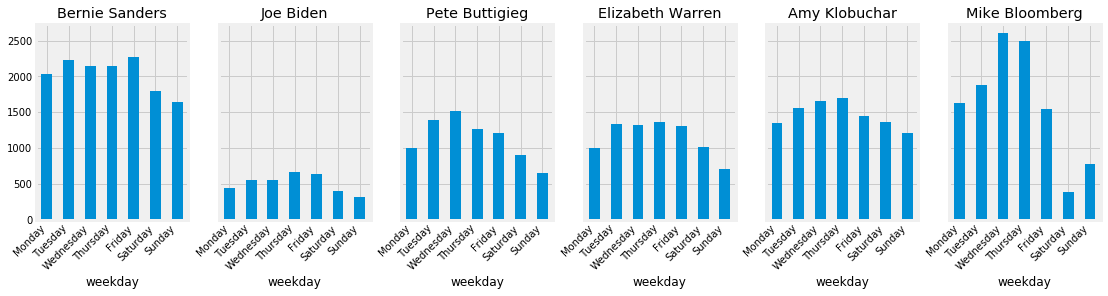

In [25]:
#plot number of tweets by weekday
fig, ax = plt.subplots(1,6, figsize=(17,4), sharey=True, sharex=True)
tweets_per_day(bernie_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[0], title='Bernie Sanders', legend=False)
tweets_per_day(joe_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[1], title='Joe Biden', legend=False)
tweets_per_day(pete_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[2], title='Pete Buttigieg', legend=False)
tweets_per_day(warren_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[3], title='Elizabeth Warren', legend=False)
tweets_per_day(amy_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[4], title='Amy Klobuchar', legend=False)
tweets_per_day(bloomberg_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[5], title='Mike Bloomberg', legend=False)
fig.autofmt_xdate(rotation=45)
plt.savefig('../images/weekly_tweet_count.png')
plt.show()

In [26]:
def polarity_bydate(df, title, yr=None, mm=None, dd=None):
    '''Creates a polarity graph based on dates selected. 
    
    Parameters
    ----------
    df : dataframe
        A pandas dataframe containing polarity scores as a column 
    
    title : string
        A title to be used for the graph
        
    yr : int (optional)
        A particular year to be filted by
    
    mm : int (optional)
        A particular month to be filted by
        
    dd : int (optional)
        A particular day to be filted by

    Returns
    -------
    A poliraty histogram
    '''
    
    try:
        
        #filter combinations
        if yr!=None and mm!=None and dd!=None:
            query = df[(df['year']==yr)&(df['month']==mm)&(df['day']==dd)]['polarity']
        elif yr!=None and mm!=None:
            query = df[(df['year']==yr)&(df['month']==mm)]['polarity']
        elif mm!=None and dd!=None:
            query = df[(df['month']==mm)&(df['day']==mm)]['polarity']
        elif yr!=None and dd!=None:
            query = df[(df['year']==yr)&(df['day']==mm)]['polarity']
        elif yr!=None:
            query = df[df['year']==yr]['polarity']
        elif mm!=None:
            query = df[df['month']==mm]['polarity']    
        elif dd!=None:
            query = df[df['day']==mm]['polarity']   

        #plot data
        fig, ax = plt.subplots(figsize=(8, 6))

        #plot histogram of the polarity values
        query.hist(bins=[-1, -0.90, -.80, -.70, -.60, -0.50, -.40 ,-.30, -0.20,-.10, 
                                0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1],
                     ax=ax,
                     color='purple')
        plt.xlabel('polarity')
        plt.title(title)
        return plt.show()
    
    except:
        
        return print('please provide a year, month, or day to filter by')

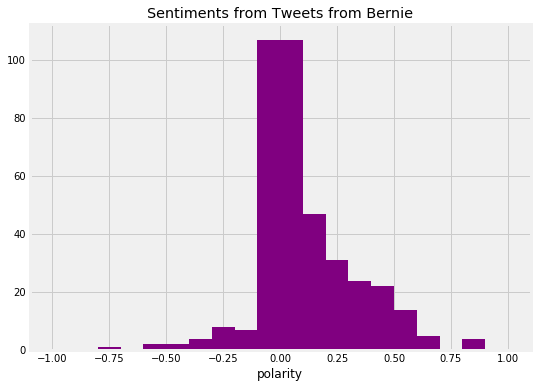

In [27]:
polarity_bydate(df=bernie_sentiment, title="Sentiments from Tweets from Bernie", yr=2020, mm=2)

In [28]:
def tweet_mention_hash_plot(df, rate='M'):
    """Creates a line graph of number text, mentions, and hashtags.    

    Parameters
    ----------
    df : dataframe
        A pandas dataframe containing text, mentions, and hashtags columns
        
    rate : string (optional)
        A method for frequency conversion and resampling of time series

    Returns
    -------
    A line graph displaying a resampled count of tweets.
    """
    df.resample(rate)[['text', 'mentions', 'hashtags']].count().plot()
    return plt.show()

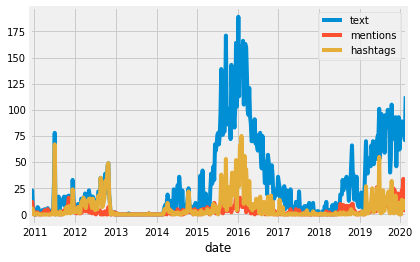

In [29]:
tweet_mention_hash_plot(bernie_sentiment, 'W')

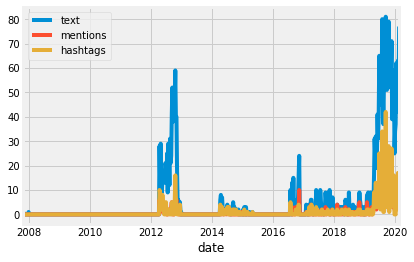

In [30]:
tweet_mention_hash_plot(joe_sentiment, 'W')

In [31]:
def data_filter(df, asof=None, dateadj=None):
    if asof is not None:
        df = df[df.index > (asof - timedelta(days=dateadj))]
    
    result = df[['text', 'polarity', 'wk_name','favorites']]
    return result

In [32]:
#candidate announcement dates
bern_ann= pd.to_datetime('2/19/2019')
joe_ann= pd.to_datetime('4/25/2019')
pete_ann= pd.to_datetime('1/23/2019')
warren_ann= pd.to_datetime('12/31/2018')
amy_ann= pd.to_datetime('2/10/2019')
bloomberg_ann= pd.to_datetime('11/8/2019')

In [33]:
def polyplot(df, rate='M'):
    n_df = df[~df['text'].isnull()]
    show_df = n_df.set_index('date')
    show_df.index = pd.to_datetime(show_df.index)
    return show_df.resample(rate)['text'].count()

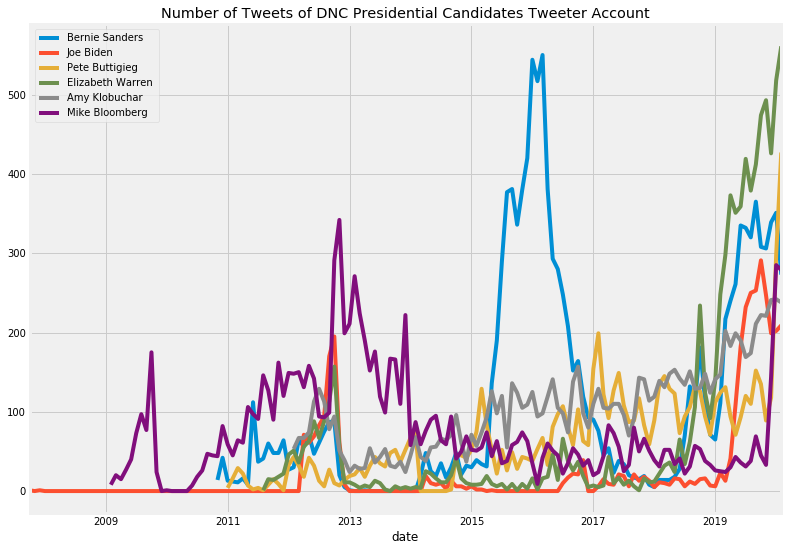

In [34]:
#plot candidates number of tweets since joining twitter
fig, ax = plt.subplots(figsize=(12,9))
polyplot(bernie_df).plot()
polyplot(joe_df).plot()
polyplot(pete_df).plot()
polyplot(warren_df).plot()
polyplot(amy_df).plot()
polyplot(bloomberg_df).plot()
labels = ['Bernie Sanders', 'Joe Biden', 'Pete Buttigieg', 'Elizabeth Warren ', 'Amy Klobuchar', 'Mike Bloomberg']
plt.legend(labels)
plt.title('Number of Tweets of DNC Presidential Candidates Tweeter Account')
plt.savefig('../images/dnc_candidates.png')
plt.show()

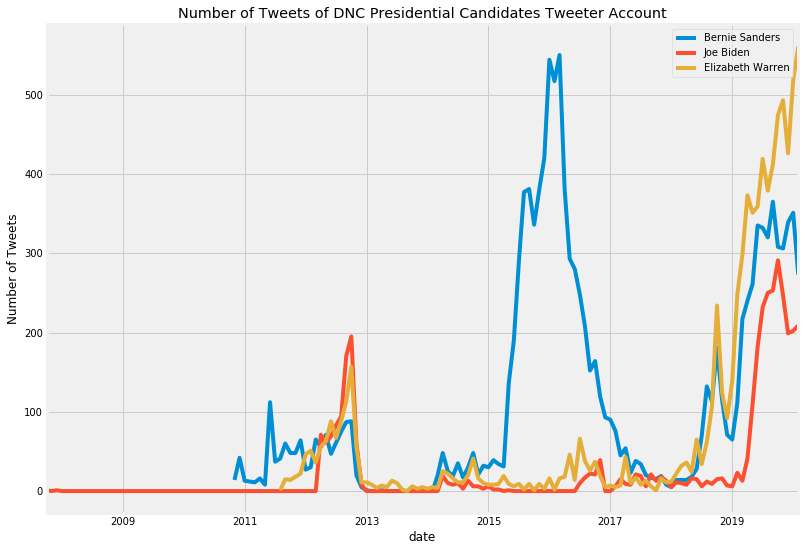

In [35]:
#plot remaining candidates number of tweets since joining twitter
fig, ax = plt.subplots(figsize=(12,9))
polyplot(bernie_df).plot()
polyplot(joe_df).plot()
polyplot(warren_df).plot()
labels = ['Bernie Sanders', 'Joe Biden', 'Elizabeth Warren']
plt.legend(labels)
plt.title('Number of Tweets of DNC Presidential Candidates Tweeter Account')
plt.ylabel('Number of Tweets')
plt.savefig('../images/dnc_candidate.png')
plt.show()

In [36]:
#transform data to fit plots using plotly
data = pd.concat([polyplot(bernie_df, rate='D'),polyplot(joe_df, rate='D'), 
                  polyplot(pete_df, rate='D'), polyplot(warren_df, rate='D'),
                  polyplot(amy_df, rate='D'), polyplot(bloomberg_df, rate='D')], axis=1)

cols = ['bernie', 'joe', 'pete', 'warren', 'amy', 'bloomberg']
data.columns = cols

In [37]:
data.head()

bernie  joe  pete  warren  amy  bloomberg
date                                                 
2007-10-24     NaN    1   NaN     NaN  NaN        NaN
2007-10-25     NaN    0   NaN     NaN  NaN        NaN
2007-10-26     NaN    0   NaN     NaN  NaN        NaN
2007-10-27     NaN    0   NaN     NaN  NaN        NaN
2007-10-28     NaN    0   NaN     NaN  NaN        NaN

In [38]:
def plot_trend(x, y):
    '''Creates plotly line graph
    '''
    title = "{} Tweets Trends".format(y.capitalize())
    fig=px.line(data, x=x, y=y, title=title)
    fig.write_image("../images/{}.png".format(y))
    return fig.show()

In [39]:
plot_trend(data.index, 'bernie')
plot_trend(data.index, 'warren')
plot_trend(data.index, 'joe')


In [40]:
def retweet_fav_reply_plot(df, title, rate='M', debates=None, asof=None, figsize=(12,8)):
    '''Creates a line graph based on dates selected, with overlapping verticle lines. 
    
    Parameters
    ----------
    df : dataframe
        A pandas dataframe containing 'retweets', 'favorites', 'replies' as columns 
    
    title : string
        A title to be used for the graph
        
    rate : string
        A method for frequency conversion and resampling of time series
        
    debates : string or list (optional)
        A dateime object to be used a verticle marker
        
    asof : int (optional)
        A particular date to be filted by

    Returns
    -------
    A line graph based on date filters assigned and verticle markets. 
    '''
    
    if asof is not None:
        df = df[df.index > (asof - timedelta(days=7))]
    
    fig, ax = plt.subplots(figsize=figsize)
    df.resample(rate)[['retweets', 'favorites', 'replies']].mean().plot(ax=ax)
    ax.get_yaxis().set_major_formatter(ff(lambda x, p: format(int(x), ',')))
    ax.legend(fancybox=True, frameon=True, framealpha=1, shadow=True, borderpad=1, title='Twitter Interaction')
    
    ax.annotate('Candidate Announcement',
            xy=(asof, np.mean(df['favorites'])),
            xycoords='data',
            xytext=(10,-100),
            textcoords='offset points',
            arrowprops=dict(headwidth=5, width=2, color='#363d46', connectionstyle="angle3,angleA=0,angleB=-90"),
            fontsize=12)
    
    ax.axvline(asof, color='blue',alpha=0.4)
    for x in debates:
        ax.axvline(x, color='green',alpha=0.4, ls='--')
    plt.savefig("images/{} Twitter_Feed.png".format(title))
    plt.ylabel('Number of Favorites')
    plt.title(title)
    return plt.show()

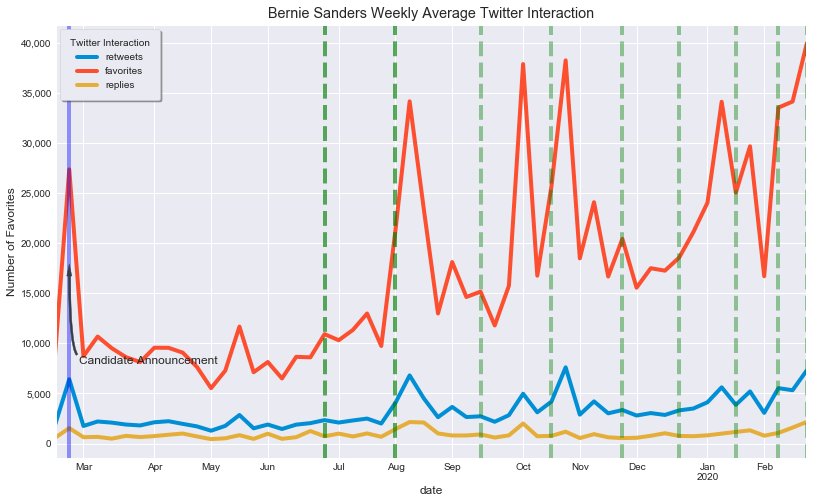

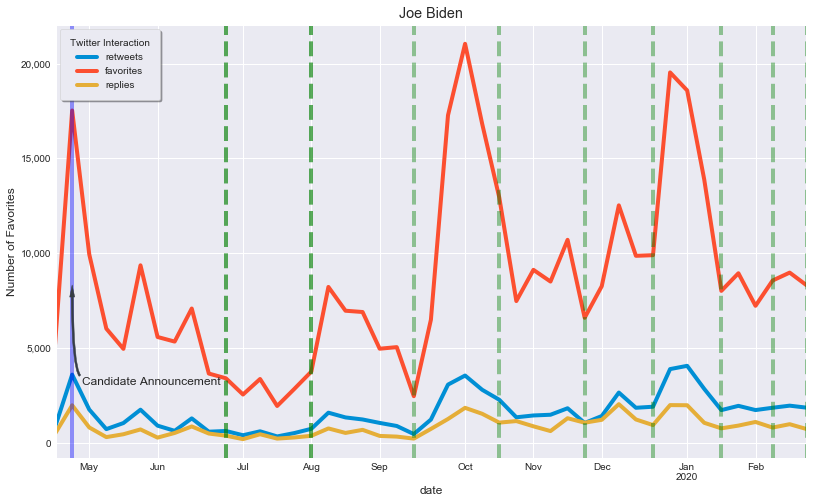

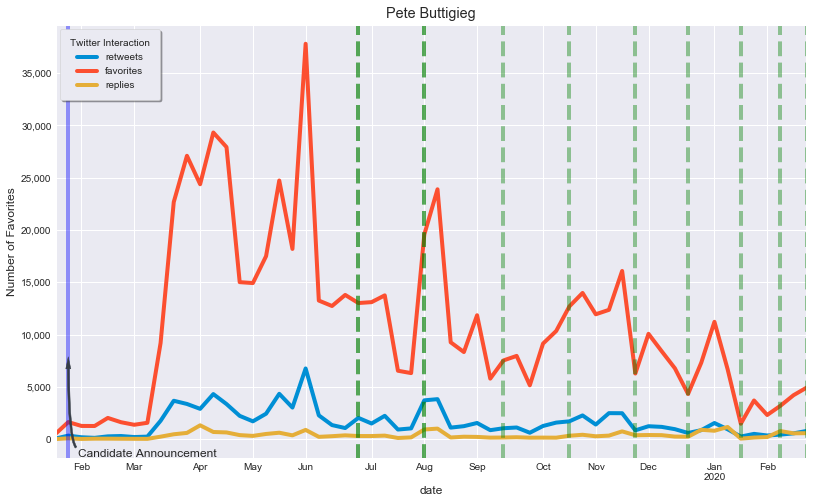

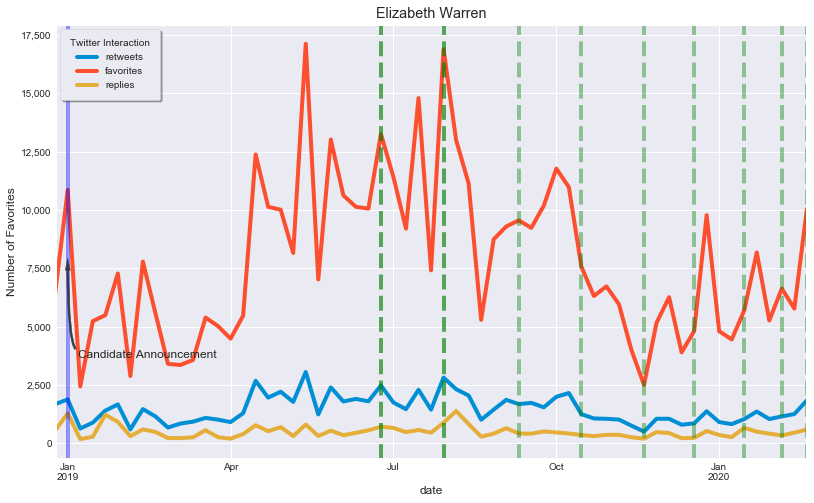

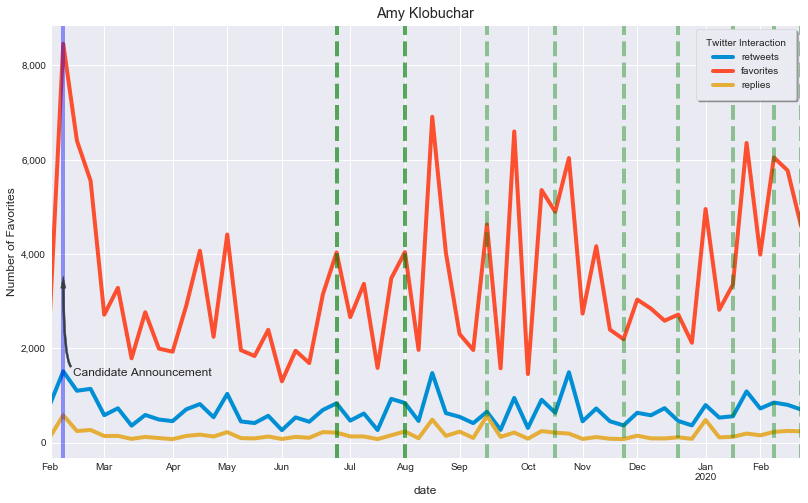

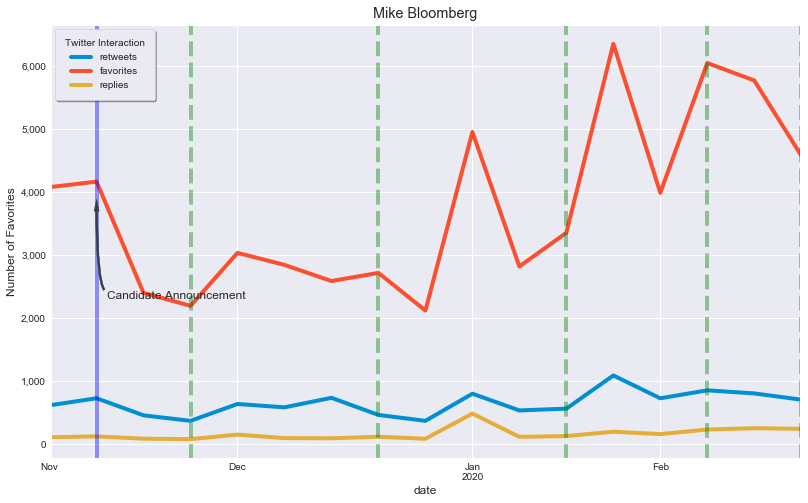

In [813]:
retweet_fav_reply_plot(bernie_sentiment, 'Bernie Sanders Weekly Average Twitter Interaction', rate='W', asof=bern_ann, debates=dnc_debates)
retweet_fav_reply_plot(joe_sentiment, 'Joe Biden', rate='W', asof=joe_ann, debates=dnc_debates)
retweet_fav_reply_plot(pete_sentiment, 'Pete Buttigieg', rate='W', asof=pete_ann, debates=dnc_debates)
retweet_fav_reply_plot(warren_sentiment, 'Elizabeth Warren', rate='W', asof=warren_ann, debates=dnc_debates)
retweet_fav_reply_plot(amy_sentiment, 'Amy Klobuchar', rate='W', asof=amy_ann, debates=dnc_debates)
retweet_fav_reply_plot(amy_sentiment, 'Mike Bloomberg', rate='W', asof=bloomberg_ann, debates=dnc_debates)

In [41]:
def election_timeperiod(df, asof=None, days_adj=7):
    cols = ['polarity','retweets', 'favorites', 'replies', 'sent_pol']
    df = df[cols]
    return df[df.index > (asof - timedelta(days=days_adj))]

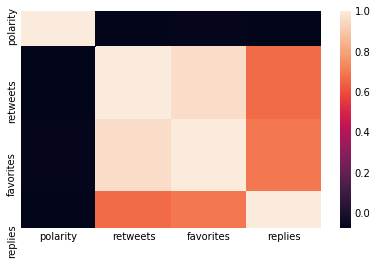

In [42]:
sns.heatmap(election_timeperiod(bernie_sentiment, bern_ann).corr())
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



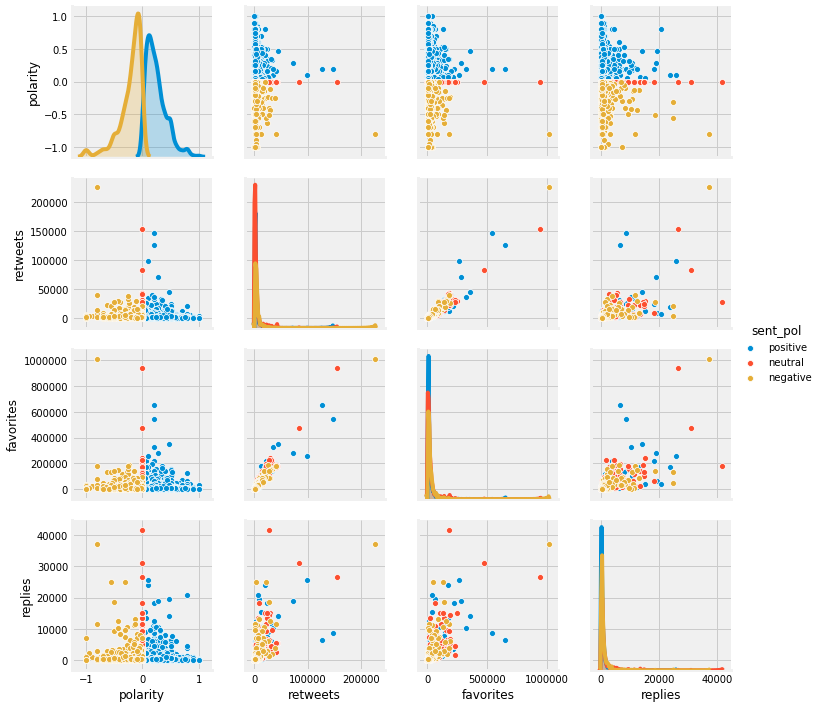

In [43]:
#scatter matrix of candidates twitter features and sentiment 
sns.pairplot(election_timeperiod(bernie_sentiment, bern_ann), hue='sent_pol')
plt.show()

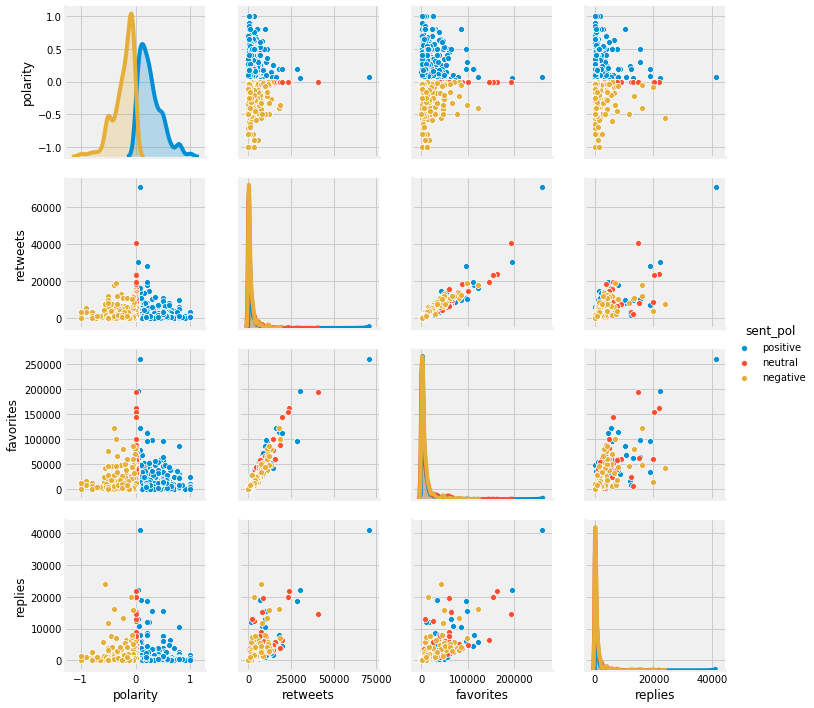

In [44]:
#scatter matrix of candidates twitter features and sentiment 
sns.pairplot(election_timeperiod(joe_sentiment, joe_ann), hue='sent_pol')
plt.show()

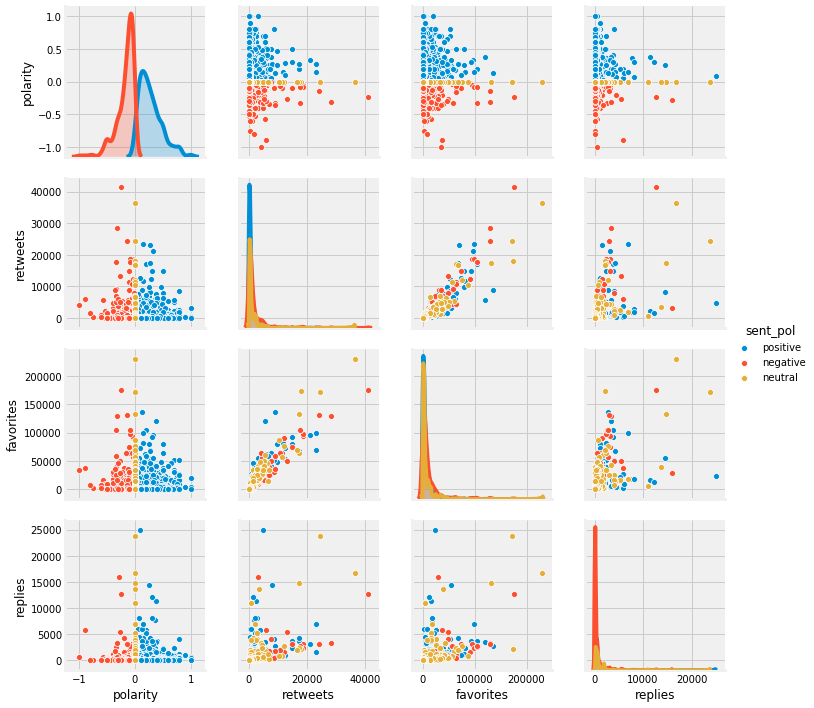

In [45]:
#scatter matrix of candidates twitter features and sentiment 
sns.pairplot(election_timeperiod(pete_sentiment, pete_ann), hue='sent_pol')
plt.show()

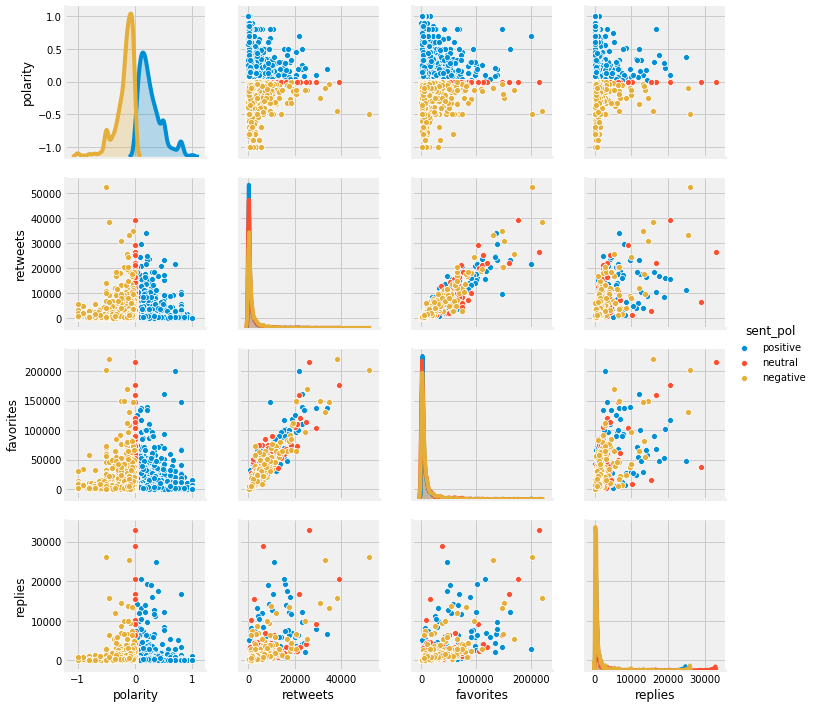

In [46]:
#scatter matrix of candidates twitter features and sentiment 
sns.pairplot(election_timeperiod(warren_sentiment, warren_ann), hue='sent_pol')
plt.show()

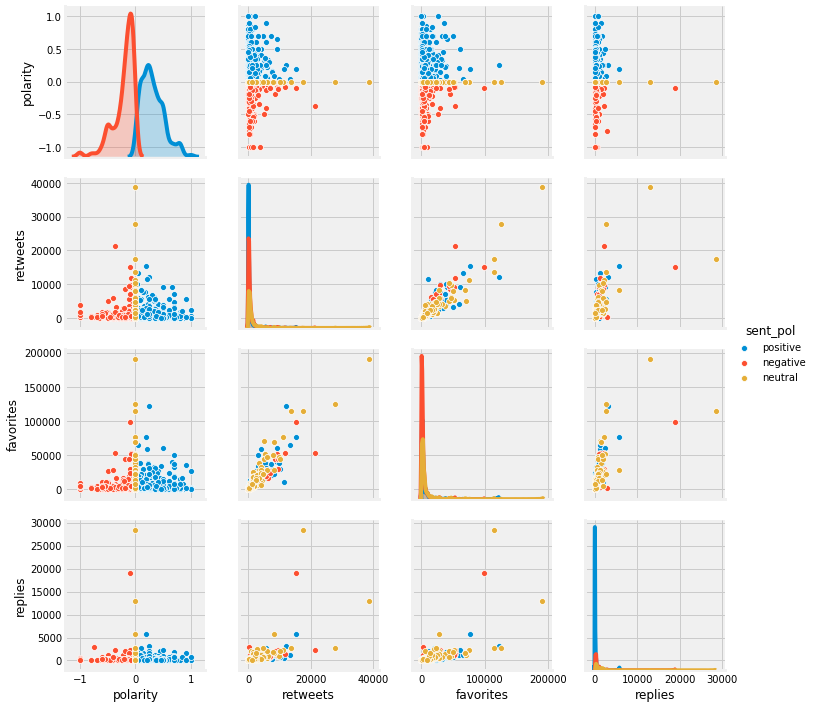

In [47]:
sns.pairplot(election_timeperiod(amy_sentiment, amy_ann), hue='sent_pol')
plt.show()

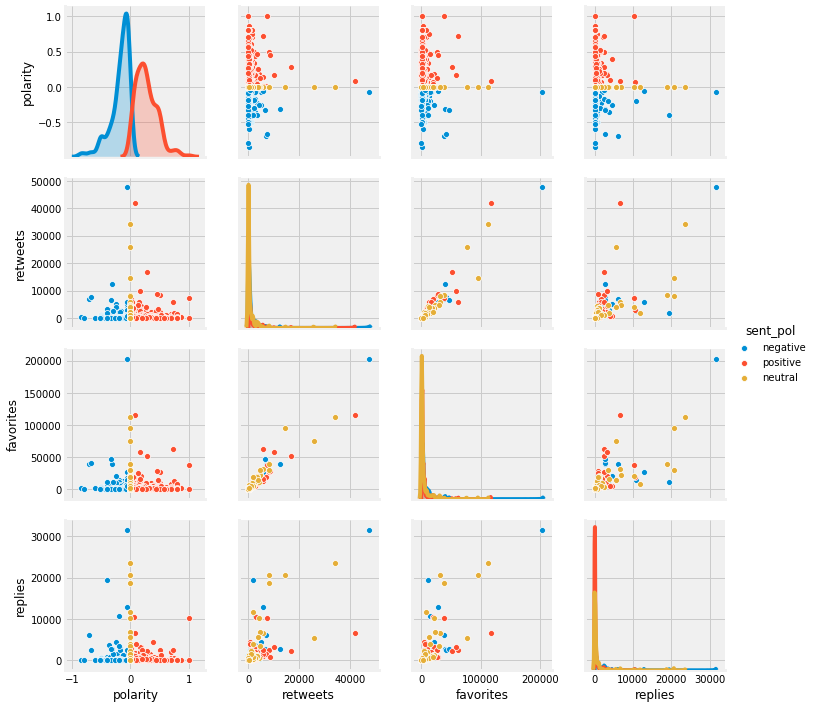

In [48]:
sns.pairplot(election_timeperiod(bloomberg_sentiment, bloomberg_ann), hue='sent_pol')
plt.show()

In [49]:
def noun_phrase_wordlist(df):
    wordlist = pd.DataFrame()
    for t in df['text']:
        tx = TextBlob(t)
        l = list(tx.noun_phrases)
        if len(l)!=0:
            wordlist = wordlist.append(l)
    return wordlist

In [50]:
bern_wordlist = noun_phrase_wordlist(bernie_sentiment)
bern_allwords = bern_wordlist.groupby(0).size()

In [51]:
joe_wordlist = noun_phrase_wordlist(joe_sentiment)
joe_allwords = joe_wordlist.groupby(0).size()

In [52]:
pete_wordlist = noun_phrase_wordlist(pete_sentiment)
pete_allwords = pete_wordlist.groupby(0).size()

In [53]:
warren_wordlist = noun_phrase_wordlist(warren_sentiment)
warren_allwords = warren_wordlist.groupby(0).size()

In [54]:
amy_wordlist = noun_phrase_wordlist(amy_sentiment)
amy_allwords = amy_wordlist.groupby(0).size()

In [55]:
bloomberg_wordlist = noun_phrase_wordlist(bloomberg_sentiment)
bloomberg_allwords = amy_wordlist.groupby(0).size()

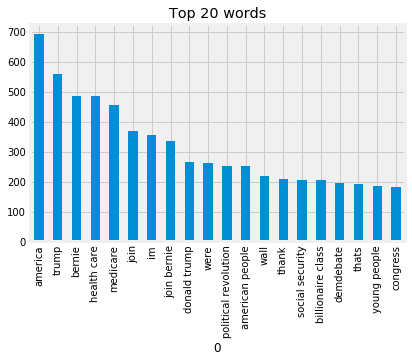

In [57]:
top20allword = bern_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

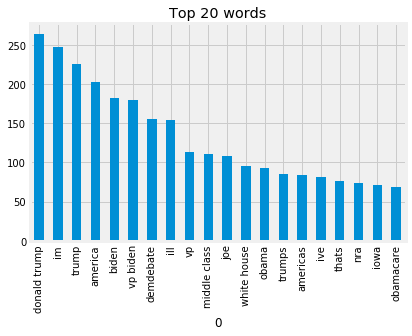

In [58]:
top20allword = joe_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

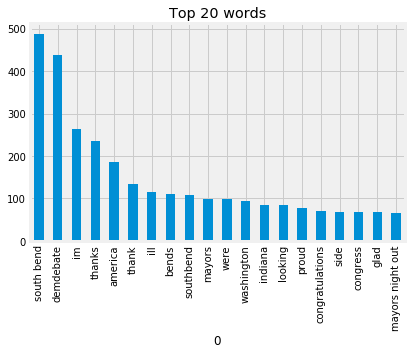

In [59]:
top20allword = pete_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

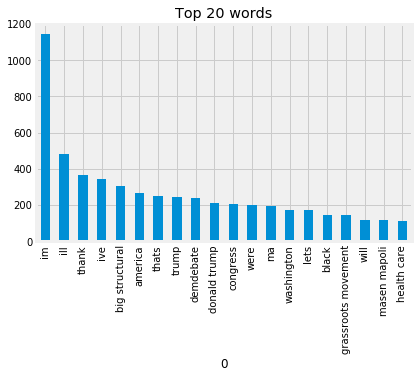

In [60]:
top20allword = warren_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

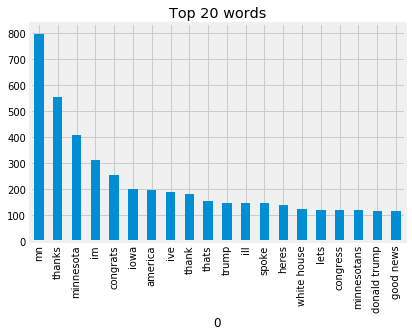

In [61]:
top20allword = bloomberg_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

In [62]:
import pyLDAvis.gensim
import gensim
from gensim import corpora

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.



In [63]:
documents = [article.lower() for article in bernie_sentiment['text']]
# 2. Create a set of tokenized documents.
docs = [word_tokenize(content) for content in documents]
# 3. Strip out stop words from each tokenized document.
stop = set(stopwords.words('english'))
docs = [[word for word in words if word not in stop] for words in docs]

In [64]:
words = []
for i in range(0,len(docs)):
    freq = nltk.FreqDist(docs[i])
    words.extend(freq.items())

In [66]:
word_features = freq.keys()
word_features

dict_keys(['campaign', 'twitter', 'looking', 'input', 'would', 'like', 'see'])

In [16]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

#########RandomForestClassifier
# Fitting classifier to the Training set
from sklearn.ensemble import RandomForestRegressor
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, r2_score
from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer

In [41]:
bern_features = data_filter(bernie_sentiment, asof=bern_ann, dateadj=7)

In [42]:
bern_features.head()

text  \
date                                                                     
2020-02-23 23:08:28  We won the popular vote in Iowa we won the New...   
2020-02-23 23:04:57  This campaign has the momentum to win but we c...   
2020-02-23 22:34:47  As president I will support the rights of both...   
2020-02-23 22:34:46  The Israeli people have the right to live in p...   
2020-02-23 20:20:37  Trump and his friends think theyre going to wi...   

                     polarity wk_name  favorites  
date                                              
2020-02-23 23:08:28  0.318182  Sunday      23609  
2020-02-23 23:04:57  0.408333  Sunday       4533  
2020-02-23 22:34:47  0.000000  Sunday      44742  
2020-02-23 22:34:46  0.140693  Sunday      97230  
2020-02-23 20:20:37  0.470000  Sunday      63002

In [299]:
bern_features.describe()

polarity     favorites
count  3807.000000  3.807000e+03
mean      0.097081  1.794003e+04
std       0.248055  3.899465e+04
min      -1.000000  1.150000e+02
25%       0.000000  3.644000e+03
50%       0.066667  7.725000e+03
75%       0.237619  1.713300e+04
max       1.000000  1.011791e+06

In [335]:
#create a corpus 
corpus = []
for i in range(len(bern_features['text'])):
    review = re.sub('[^a-zA-Z]',' ',bern_features['text'][i])
    review = review.lower()
    review = review.split() #convert into list
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
bern_features['corpus'] = corpus
X_ = bern_features[['corpus', 'polarity']]

In [ ]:
X_sw = tfidf.fit_transform(corpus_sw).toarray()

In [ ]:
X_f = X_.reset_index().merge(pd.DataFrame(tfidf.fit_transform(corpus).toarray()), left_index=True, right_index=True)

In [44]:
ngram_vec = CountVectorizer(ngram_range=(3,3))
X_counts = ngram_vec.fit_transform(corpus)

In [4]:
X_counts.shape                                                                    
print(ngram_vec.get_feature_names()[:100])                                                                              

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_counts.toarray(), y, test_size = 0.20, random_state = 0)

In [48]:
regressor_ngram = RandomForestRegressor(n_estimators=100, criterion='mse', max_features=0.1)

In [49]:
regressor_ngram.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [50]:
y_pred_ngram = regressor_ngram.predict(X_test)

In [238]:
regressor.fit_transform(X_example)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sw, y, test_size = 0.20, random_state = 0)

In [46]:
y= bern_features['favorites'].values

In [85]:
ngrams_tf = TfidfVectorizer(ngram_range=(2,2), analyzer=corpus)

distribution of tweet counts
try not removing stopwords
bygrams
doc freq (decrease size of corpus )


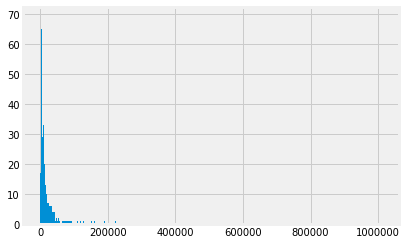

In [89]:
plt.hist(y_test, bins=1000)
plt.show()

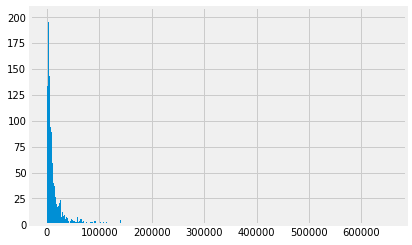

In [90]:
plt.hist(y_train, bins=1000)
plt.show()

In [776]:
#bag of words model
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(corpus).toarray()

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [348]:
#assigning 
regressor = RandomForestRegressor(n_estimators=600, n_jobs=-1, max_features=.5)
regressor2 = RandomForestRegressor(n_estimators=300, min_samples_split=3, max_features=.5)
regressor3 = RandomForestRegressor(n_estimators=700, n_jobs=-1, min_samples_leaf=3, max_features=.5)
regressor_sw = RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [349]:
regressor.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [282]:
regressor2.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [286]:
regressor3.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
regressor_sw.fit(X_train,y_train)

In [350]:
y_pred = regressor.predict(X_test)
y_pred2 = regressor2.predict(X_test)
y_pred3 = regressor3.predict(X_test)
y_pred_sw = regressor_sw.predict(X_test)

In [353]:
print('Mean Squared Log Error:', round(metrics.mean_squared_log_error(y_test, y_pred),2))
print('Mean Squared Log Error:', round(metrics.mean_squared_log_error(y_test, y_pred_ngram),2))
print('Mean Squared Log Error:', round(metrics.mean_squared_log_error(y_test, y_pred2),2))
print('Mean Squared Log Error:', round(metrics.mean_squared_log_error(y_test, y_pred3),2))

Mean Squared Log Error: 1.19
Mean Squared Log Error: 3.45
Mean Squared Log Error: 1.2
Mean Squared Log Error: 1.26


In [355]:
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred_ngram),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred2),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred3),2))

Mean Squared Error: 2816823381.32
Mean Squared Error: 3946866005.31
Mean Squared Error: 2819057958.46
Mean Squared Error: 2889323506.43


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [360]:
pol_re.score(X_train, y_train)

0.8258891888672576

In [361]:
regressor.score(X_test, y_test)

0.1255731461176044

In [356]:
# Make predictions on test data
predictions = regressor.predict(X_test)

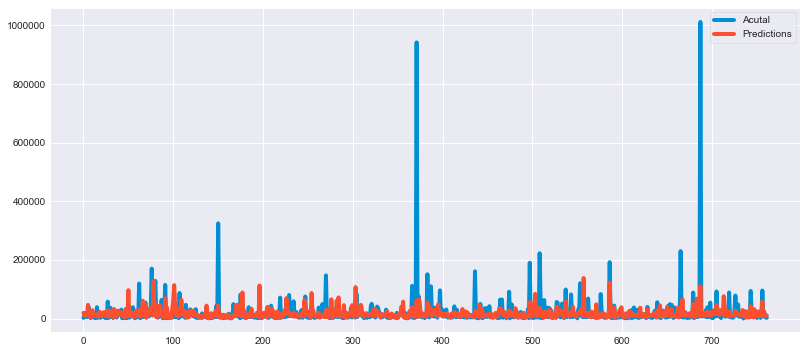

In [364]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(y_test)
plt.plot(predictions)
labels = ['Acutal', 'Predictions']
plt.legend(labels)
plt.show()

In [373]:
brn_df = bernie_sentiment[['wk_name', 'sent_pol', 'month']]
bern_f = pd.get_dummies(brn_df, columns=['wk_name', 'sent_pol', 'month'], drop_first=True)

In [384]:
bern_f.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14266 entries, 2020-02-23 23:08:28 to 2010-11-17 20:46:06
Data columns (total 19 columns):
wk_name_Monday       14266 non-null uint8
wk_name_Saturday     14266 non-null uint8
wk_name_Sunday       14266 non-null uint8
wk_name_Thursday     14266 non-null uint8
wk_name_Tuesday      14266 non-null uint8
wk_name_Wednesday    14266 non-null uint8
sent_pol_neutral     14266 non-null uint8
sent_pol_positive    14266 non-null uint8
month_2              14266 non-null uint8
month_3              14266 non-null uint8
month_4              14266 non-null uint8
month_5              14266 non-null uint8
month_6              14266 non-null uint8
month_7              14266 non-null uint8
month_8              14266 non-null uint8
month_9              14266 non-null uint8
month_10             14266 non-null uint8
month_11             14266 non-null uint8
month_12             14266 non-null uint8
dtypes: uint8(19)
memory usage: 376.2 KB


In [385]:
y_ = bernie_sentiment['favorites'].values
X_ = bern_f

In [386]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.20, random_state = 0)

In [387]:
rf = RandomForestRegressor()

In [388]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [394]:
y_pred = rf.predict(X_test)

In [395]:
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))

Mean Squared Error: 534919835.4


In [390]:
# Make predictions on test data
predictions = rf.predict(X_test)
# Performance metrics
errors = abs(predictions - y_test)
print('Metrics for Random Forest Trained')
print('Average absolute error:', round(np.mean(errors), 2))

Metrics for Random Forest Trained
Average absolute error: 8934.21 degrees.


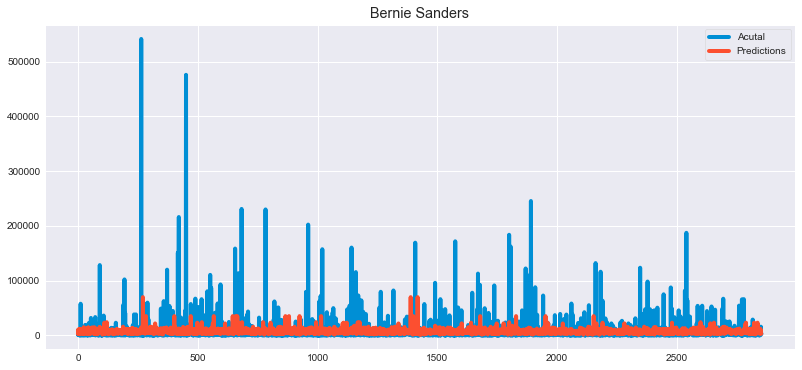

In [417]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(y_test)
plt.plot(predictions)
labels = ['Acutal', 'Predictions']
plt.legend(labels)
plt.title('Bernie Sanders')
plt.show()

In [420]:
bern_features

text  \
date                                                                     
2020-02-23 23:08:28  We won the popular vote in Iowa we won the New...   
2020-02-23 23:04:57  This campaign has the momentum to win but we c...   
2020-02-23 22:34:47  As president I will support the rights of both...   
2020-02-23 22:34:46  The Israeli people have the right to live in p...   
2020-02-23 20:20:37  Trump and his friends think theyre going to wi...   

                     polarity wk_name  favorites  
date                                              
2020-02-23 23:08:28  0.318182  Sunday      23609  
2020-02-23 23:04:57  0.408333  Sunday       4533  
2020-02-23 22:34:47  0.000000  Sunday      44742  
2020-02-23 22:34:46  0.140693  Sunday      97230  
2020-02-23 20:20:37  0.470000  Sunday      63002

In [443]:
def create_corpus(df, from_date=None, to_date=None):
    
    df = df[(df['text'].index >= pd.to_datetime(from_date))&
             (df['text'].index <= pd.to_datetime(to_date))]
    y = df[(df['favorites'].index >= pd.to_datetime(from_date))&
             (df['favorites'].index <= pd.to_datetime(to_date))]
    corpus = []
    for i in range(len(df['text'])):
        review = re.sub('[^a-zA-Z]',' ',df['text'][i])
        review = review.lower()
        review = review.split() #convert into list
        ps = PorterStemmer()
        review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
        review = ' '.join(review)
        corpus.append(review)
    return corpus, y['favorites']

In [447]:
corpus_t, y_t = create_corpus(bernie_sentiment, from_date='1-1-2020', to_date='1-31-2020')

In [469]:
corpus_ts, y_ts = create_corpus(bernie_sentiment, from_date='2-1-2020', to_date='2-7-2020')

In [539]:
#bag of words model
tfidf = TfidfVectorizer(stop_words='english')
X_t = tfidf.fit_transform(corpus_t).toarray()
X_ts = tfidf.fit_transform(corpus_ts).toarray()

In [540]:
X_train=X_t
y_train=y_t

X_test=X_ts
y_test=y_ts

In [541]:
X_train.shape, y_train.shape

((342, 1411), (342,))

In [542]:
X_test.shape, y_test.shape

((45, 337), (45,))

In [543]:
rf_t = RandomForestRegressor()

In [544]:
rft = rf_t.fit(X_train,y_train)

In [504]:
bern_f.head()

wk_name_Monday  wk_name_Saturday  wk_name_Sunday  \
date                                                                    
2020-02-23 23:08:28               0                 0               1   
2020-02-23 23:04:57               0                 0               1   
2020-02-23 22:34:47               0                 0               1   
2020-02-23 22:34:46               0                 0               1   
2020-02-23 20:20:37               0                 0               1   

                     wk_name_Thursday  wk_name_Tuesday  wk_name_Wednesday  \
date                                                                        
2020-02-23 23:08:28                 0                0                  0   
2020-02-23 23:04:57                 0                0                  0   
2020-02-23 22:34:47                 0                0                  0   
2020-02-23 22:34:46                 0                0                  0   
2020-02-23 20:20:37                 0                0                  0   

                     sent_pol_neutral  sent_pol_positive  month_2  month_3  \
date                                                                         
2020-02-23 23:08:28                 0                  1        1        0   
2020-02-23 23:04:57                 0                  1        1        0   
2020-02-23 22:34:47                 1                  0        1        0   
2020-02-23 22:34:46                 0                  1        1        0   
2020-02-23 20:20:37                 0                  1        1        0   

                     month_4  month_5  month_6  month_7  month_8  month_9  \
date                                                                        
2020-02-23 23:08:28        0        0        0        0        0        0   
2020-02-23 23:04:57        0        0        0        0        0        0   
2020-02-23 22:34:47        0        0        0        0        0        0   
2020-02-23 22:34:46        0        0        0        0        0        0   
2020-02-23 20:20:37        0        0        0        0        0        0   

                     month_10  month_11  month_12  
date                                               
2020-02-23 23:08:28         0         0         0  
2020-02-23 23:04:57         0         0         0  
2020-02-23 22:34:47         0         0         0  
2020-02-23 22:34:46         0         0         0  
2020-02-23 20:20:37         0         0         0

In [816]:
def time_df(df, from_date=None, to_date=None):
    
    df = df[(df.index >= pd.to_datetime(from_date))&
             (df.index <= pd.to_datetime(to_date))]
    
    new_df = df[['wk_name', 'sent_pol', 'month', 'favorites']]
    new_df = pd.get_dummies(new_df, columns=['wk_name', 'sent_pol', 'month'], drop_first=True)
    return new_df


In [817]:
train_df = time_df(bernie_sentiment,from_date='1-1-2020', to_date='1-31-2020')
test_df = time_df(bernie_sentiment,from_date='2-1-2020', to_date='2-8-2020')

In [818]:
y_train = train_df.pop('favorites')
X_train = train_df

In [819]:
X_train.shape

(342, 8)

In [820]:
y_test= test_df.pop('favorites')
X_test= test_df

In [821]:
X_test.shape

(59, 8)

In [836]:
rfr_model = RandomForestRegressor(n_estimators=200)

In [837]:
rgr = rfr_model.fit(X_train,y_train)

In [838]:
prediction = rgr.predict(X_test)

In [839]:
# Make predictions on test data
predictions = rgr.predict(X_test)
# Performance metrics
errors = abs(prediction - y_test)
print('Metrics for Random Forest Trained')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')

Metrics for Random Forest Trained
Average absolute error: 28491.11 degrees.


In [840]:
db = y_test.reset_index()
graph = db.merge(pd.DataFrame(prediction, columns=['prediction']), left_index=True, right_index=True)

In [841]:
new_db = graph.merge(round(pd.DataFrame(tf['favorites'].rolling(15).mean().dropna())).astype(int), left_on='date', right_on='date')

In [842]:
new_db.head()

date  favorites_x    prediction  favorites_y
0 2020-02-06 21:00:32        78945  19725.422841        34773
1 2020-02-06 19:04:34       140518  51499.223942        42799
2 2020-02-06 18:27:27       157405  19725.422841        52726
3 2020-02-06 18:02:32         8596  19725.422841        51179
4 2020-02-06 17:18:18         9585  19725.422841        47267

In [843]:
graph['prediction'] = graph['prediction'].map(lambda x: round(x))

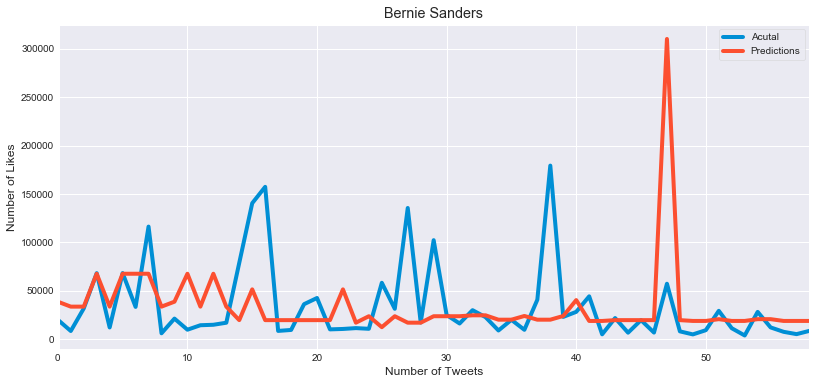

In [844]:
fig, ax = plt.subplots(figsize=(12,6))
graph['favorites'].plot()
graph['prediction'].plot()

labels = ['Acutal', 'Predictions']
plt.legend(labels)
plt.title('Bernie Sanders')
plt.xlabel('Number of Tweets')
plt.ylabel('Number of Likes')
plt.show()

In [848]:
print('Mean Squared Log Error:', round(metrics.mean_squared_log_error(y_test, prediction),2))

Mean Squared Log Error: 1.03


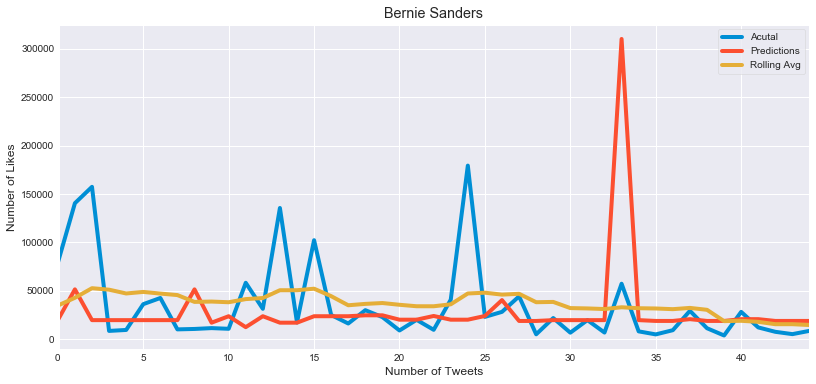

In [853]:
fig, ax = plt.subplots(figsize=(12,6))
new_db['favorites_x'].plot()
new_db['prediction'].plot()
new_db['favorites_y'].plot()

labels = ['Acutal', 'Predictions', 'Rolling Avg']
plt.legend(labels)
plt.title('Bernie Sanders')
plt.xlabel('Number of Tweets')
plt.ylabel('Number of Likes')
plt.show()

In [56]:
plot_trend(data.index, 'bernie')